In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

duration = 1000#50000
L=cbrt(100)
Ca=5.
Cb=1.
k0= 0.1

def write(name,obs):
    f=open(name,'w')
    data = np.array(obs.data()).T
    np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
    f.close()        
    print('saving into',name)        

def singlerun_spa(rm,D):   
    V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm*1.0208582)    
    Nb=int(Cb*V)
    Na=int(Ca*V)
    keff = k0/(Nb/V)/(Na/V)
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    dt = (2*rm*1.0208582)**2 / (6*D)
    assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm*1.0208582  }
        B | {'D': D, 'radius':rm*1.0208582  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | ka
    m = get_model()
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rm*1.0208582)
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = spatiocyte.SpatiocyteSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_bd_{}_rm{:.3}_D{:.3}_L{:.3}b_dur{}'.format('spa',rm,D,L,duration),obs)
    return obs

def singlerun_e(rm,D):
    V = L**3 
    keff = k0/Ca/Cb
    Nb=100
    Na=500
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    dt = (2*rm)**2 / (6*D)
    M = max(int(min(cbrt(Na + Nb), L / (2 * rm))), 3)
    assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm  }
        B | {'D': D, 'radius':rm  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    w = egfrd.EGFRDWorld(Real3(L,L,L),Integer3(M,M,M))
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = egfrd.EGFRDSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_bd_{}_rm{:.3}_D{:.3}_L{:.3}b_dur{}'.format('egfrd',rm,D,L,duration),obs)
    return obs

def singlerun_g(rm,D):
    K=int(L/2/rm)
    V = L**3 
    Nb=100
    Na = 500
    dt = (2*rm)**2 / (6*D)
    keff = k0/Ca/Cb
    with species_attributes():
        A | {'D': D}
        B | {'D': D}

    with reaction_rules():
        ~A > A | k0
        A + B >B | keff
    m = get_model()
    w = gillespie.GillespieWorld(Real3(L,L,L))
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = gillespie.GillespieSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_gillespie_rm{:.3}_D{:.3}_L{:.3}_dur{}'.format(rm,D,L,duration),obs)
    return obs

import time
T=[]
#T.append(time.time())
#for job in [[0.05,0.02]]:#[0.05,0.1]
#    obs_spa=singlerun_spa(job[0],job[1])
#T.append(time.time())
#for job in [[0.05,0.02]]:#[0.05,0.1]
#    obs_g=singlerun_g(job[0],job[1])    
T.append(time.time()) 
for job in [[0.05,0.02]]:#[0.05,0.1]
    obs_e=singlerun_e(job[0],job[1])
T.append(time.time())

In [2]:
T=np.array(T)
dt=T[1:]-T[:-1]
print(dt)
print(dt/60)
T

[2728.95741153]
[45.48262353]


array([1.52421633e+09, 1.52421906e+09])

Gillespie
4.971399559903651 0.03876783666864412
Spatiocyte
4.965585385718292 0.04167625665310069
eGFRD
4.949770773138359 0.044591457420175305
Spatiocyte
4.789086291066999 0.04244611049436438
eGFRD
4.768418877606807 0.04368547965876151


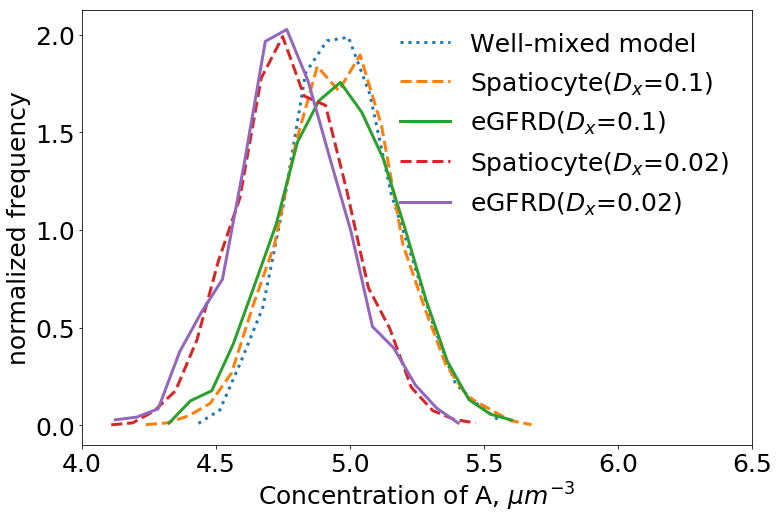

In [1]:
from ecell4 import *
from math import pi as pi
import math
import numpy as np
import matplotlib.pylab as plt
from scipy import special
%matplotlib inline

fs=25
lw=3

def getc(rm,D,L,sim,dur):
    if (sim=='Spatiocyte'):
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),1.0208582*rm)  
        d=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{}_D{}_L{}b_dur{}'.format(rm,D,L,dur),delimiter=',')    
    elif (sim=='eGFRD'): 
        V=L**3
        d=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{}_D{}_L{}b_dur{}'.format(rm,D,L,dur),delimiter=',')    
    elif (sim=='Gillespie'):
        V=L**3
        d=np.genfromtxt('/home/chew/outputdata/sturrock_gillespie_rm{}_D{}_L{}_dur{}'.format(rm,D,L,dur),delimiter=',')            
    else:
        V=L**3
        d=np.genfromtxt('/home/chew/outputdata/sturrock_bd_meso_rm{}_D{}_L{}_dur{}'.format(rm,D,L,dur),delimiter=',')    
    
    ll= d.shape[0]
    con=((d[:,1][int(ll*0.3):])/V)
    ave=np.mean(con)
    noise=np.std(con)/ave
    print(sim)
    print(ave,noise)
    hi,be=np.histogram(con,bins=np.arange(min(con),max(con),0.08),normed=True)
    if (sim=='Gillespie'):
        ax1.plot((be[1:]+be[:-1])*0.5,hi,':',label='Well-mixed model',linewidth=lw)
    elif (sim=='eGFRD'): 
        ax1.plot((be[1:]+be[:-1])*0.5,hi,'-',label=sim+'($D_x$='+str(D)+')',linewidth=lw)
    elif (sim=='Spatiocyte'): 
        ax1.plot((be[1:]+be[:-1])*0.5,hi,'--',label=sim+'($D_x$='+str(D)+')',linewidth=lw)
    else:
        ax1.plot((be[1:]+be[:-1])*0.5,hi,'-.',label=sim+'($D_x$='+str(D)+')',linewidth=lw)    
    return 

fig,ax1=plt.subplots(1,1,figsize=(12,8))
getc(0.5,0.1,4.64,'Gillespie',10000)
getc(0.05,0.1,4.64,'Spatiocyte',50000)
getc(0.05,0.1,4.64,'eGFRD',10000)
getc(0.05,0.02,4.64,'Spatiocyte',50000)
getc(0.05,0.02,4.64,'eGFRD',5000)

ax1.set_xlim(4,6.5)
ax1.legend(fontsize=fs,frameon=False)
ax1.tick_params(labelsize=fs)
ax1.set_xlabel('Concentration of A, $\mu m^{-3}$',fontsize=fs)
ax1.set_ylabel('normalized frequency',fontsize=fs)
fig=plt.gcf()
plt.savefig('/home/chew/ecellwork/figure/fig5c.eps',format='eps',dpi=900)